In [65]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
#from scipy import interp, arange, exp
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull

In [66]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [67]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/output_repar_03-01/'               # Harmon server
name_project

'project_repartition_v3.0/output_repar_01-01/'

In [68]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-01/


In [69]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [70]:
name_project_probes = info_basic['name_project_probes']
name_project_targets = info_basic['name_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, name_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, name_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/
dir_project_targets:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-02/


In [71]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

In [72]:
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']

In [73]:
dir_image = dir_project+info_basic['dir_image']
dir_disp_probes  = dir_project_probes + info_basic_probes['dir_disp'] 
print('dir_image: ', dir_image)
print('dir_disp: ', dir_disp_probes)

dir_image:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-01/image_01-01/
dir_disp:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/autopick17-01//


In [74]:
stalistname_all = info_basic_probes['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_all = stainfo['latitude'].tolist() 
lon_all = stainfo['longitude'].tolist()

In [75]:
stalistname = dir_project_probes+ info_basic_probes['stalistname']
stainfo_probes = pd.read_excel(stalistname,sheet_name=None)
stalistname = dir_project_targets+ info_basic_targets['stalistname']
stainfo_targets = pd.read_excel(stalistname,sheet_name=None)

In [76]:
loc_probes = pd.read_excel(dir_project_probes + 'subwork_location.xlsx',sheet_name='location')
loc_targets = pd.read_excel(dir_project_targets + 'subwork_location.xlsx',sheet_name='location')

In [77]:
f = info_basic_bi_probes['f']
c = np.linspace(info_basic_probes['c_min'],info_basic_probes['c_max'],info_basic_probes['c_num'])

In [78]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [79]:
ds_probe_all = {}
for probe in info_basic_probes['key_subworks']:
    file_ds = dir_project_probes  + info_basic_probes['dir_ds'] + 'ds_'+probe+'.h5'
    ds = h5py.File(file_ds,'r')
    ds_probe_all[probe] = ds['ds_remove'][0]
    ds.close()

### Cluster

In [80]:
phase_mean = info_basic_bi['phase_mean']
ks_f_range = info_basic['ks_f_range']
ks_f_range

[10, 15]

In [81]:
def extract_probes(key_subwork):
    global dir_project
    global dir_project_probes
    global dir_project_targets
    global probes
    global stainfo_targets

    stas = stainfo_targets[key_subwork]['Station'].tolist()
    # 生成sta的包络
    #hull_sta = ConvexHull(stainfo_targets[key_subwork][['Longitude','Latitude']])

    stas2key = [sta[1:3]+'-'+sta[3:] for sta in stas]
    probes_this = []
    for sta in stas2key:
        if sta in probes:
            probes_this.append(sta)
    return probes_this

In [82]:
def find_nearest(lon_this,lat_this,lon_all,lat_all):
    lon_all = np.array(lon_all)
    lat_all = np.array(lat_all)
    lon_all = lon_all.reshape(-1,1)
    lat_all = lat_all.reshape(-1,1)
    dist = np.sqrt((lon_all-lon_this)**2+(lat_all-lat_this)**2)
    min_dist = np.min(dist)
    index = np.where(dist==min_dist)[0][0]
    return index

In [83]:
def cluster_filter(target):
    global flag_err
    global flag_plot
    global dir_image
    global flag_pass
    global ds_probe_all
    global targets
    global probes
    global lon_all
    global lat_all
    global lon_sta
    global stations_accept_all
    global lon_centroid_all 
    global lat_centroid_all 
    global probe_accept_all
    # extract all disp
    probes_this = extract_probes(target)
    stations = set()
    for probe in probes_this:
        stations_this = [station for station in stainfo_probes[probe]['Station'].tolist()]
        stations = stations.union(set(stations_this))
        
    stations = list(stations)

    lon_this = []
    lat_this = []
    for probe in probes_this:
        lon_this.append(loc_probes['lon_centroid'][probes.index(probe)])
        lat_this.append(loc_probes['lat_centroid'][probes.index(probe)])
    # 读取全部autopick dispersion curves
    disp_all = {}
    for probe in probes_this:
        file_ds = dir_project_probes  + info_basic_probes['dir_disp'] + 'autopick_'+probe+'.txt'
        disp = np.loadtxt(file_ds,delimiter=',')
        index = np.where((disp[:,0]>=ks_f_range[0]) & (disp[:,0]<=ks_f_range[1]))[0]
        disp_all[probe] = disp[index,:]
    phase_this = [phase_mean[probe] for probe in probes_this]

    # find central probe and cluster based on it
    lon_centroid = np.mean(lon_this)
    lat_centroid = np.mean(lat_this)
    index = find_nearest(lon_centroid,lat_centroid,lon_this,lat_this)
    c_ref = phase_this[index]
    probe_ref = probes_this[index]
    
    phase_sort = np.sort(phase_this)
    index_phase = range(len(phase_sort))
    probe_accept = []
    phase_accept = []
    lon_accept = []
    lat_accept = []
    for probe in probes_this:
        if phase_mean[probe] >= c_ref*(1-flag_err) and phase_mean[probe] <= c_ref*(1+flag_err):
            probe_accept.append(probe)
            lon_accept.append(loc_probes['lon_centroid'][probes.index(probe)])
            lat_accept.append(loc_probes['lat_centroid'][probes.index(probe)])
            phase_accept.append(phase_mean[probe])

    # ks analysis
    lon_centroid = np.mean(lon_accept)
    lat_centroid = np.mean(lat_accept)
    index = find_nearest(lon_centroid,lat_centroid,lon_accept,lat_accept)
    probe_ref = probe_accept[index]

    f_sample = np.linspace(ks_f_range[0],ks_f_range[1],200,endpoint=False)
    c_pick = {}
    for probe in probes_this:
        c_pick[probe] = []
        file_ds = dir_project_probes  + info_basic_probes['dir_disp'] + 'autopick_'+probe+'.txt'
        disp = np.loadtxt(file_ds,delimiter=',')
        index = np.where((disp[:,0]>=ks_f_range[0]) & (disp[:,0]<=ks_f_range[1]))[0]
        disp = disp[index,:]
        f_this = disp[:,0]
        c_this = disp[:,1]
        # 生成插值函数,可以外推
        #f = interpolate.interp1d(f_this,c_this,kind='cubic')
        f = interpolate.interp1d(f_this,c_this,kind='cubic',fill_value='extrapolate')
        c_pick[probe] = f(f_sample)

    f_pick_ref = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,0]
    c_pick_ref0 = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,1]
    #f = interpolate.interp1d(f_pick_ref,c_pick_ref0,kind='cubic')
    f = interpolate.interp1d(f_pick_ref,c_pick_ref0,kind='cubic',fill_value='extrapolate')
    c_pick_ref = f(f_sample)

    ks_p_values = []
    ks_statistic = []
    for probe in probe_accept:
        ks_p_values.append(ks_2samp(c_pick[probe]-np.mean(c_pick[probe]),c_pick_ref-np.mean(c_pick_ref))[1])
        ks_statistic.append(ks_2samp(c_pick[probe]-np.mean(c_pick[probe]),c_pick_ref-np.mean(c_pick_ref))[0])

    # original partition
    sta_original = set()
    for probe in probes_this:
        sta_original = sta_original.union(set(stainfo_probes[probe]['Station'].tolist()))
    sta_original = list(sta_original)
    lon_original = []
    lat_original = []
    for sta in sta_original:
        index = stalist_all.index(sta)
        lon_original.append(lon_all[index])
        lat_original.append(lat_all[index])


    index_pass = np.array(ks_statistic)<flag_pass
    probe_pass = np.array(probe_accept)[index_pass]
    lon_pass = np.array(lon_accept)[index_pass]
    lat_pass = np.array(lat_accept)[index_pass]
    ks_statistic_pass = np.array(ks_statistic)[index_pass]

    # new partition
    sta_pass = set()
    lon_pass_all = []
    lat_pass_all = []
    for probe in probe_pass:
        sta_pass = sta_pass.union(set(stainfo_probes[probe]['Station'].tolist()))
    sta_pass = list(sta_pass)
    for sta in sta_pass:
        index = stalist_all.index(sta)
        lon_pass_all.append(lon_all[index])
        lat_pass_all.append(lat_all[index])
    stations_accept_all[target] = sta_pass
    lon_centroid_all[target] = np.mean(lon_pass_all)
    lat_centroid_all[target] = np.mean(lat_pass_all)
    

    if flag_plot == 1:
        fig = plt.figure(figsize=(18,15))
        ax = fig.add_subplot(332)
        ax.scatter(index_phase,phase_sort,c='k',s=20)
        ax.axhline(y=c_ref,color='b',ls='--',label='central mean')
        ax.axhline(y=c_ref*(1-flag_err),color='r',ls='--',label='tolerance range')
        ax.axhline(y=c_ref*(1+flag_err),color='r',ls='--')
        ax.set_xlabel('probe index')
        ax.set_ylabel('phase velocity (km/s)')
        ax.legend()

        ax = fig.add_subplot(331)
        ax.scatter(lon_all,lat_all,c='k',s=1)
        im = ax.scatter(lon_this,lat_this,c=phase_this,s=20,cmap='jet')
        ax.scatter(lon_centroid,lat_centroid,c='k',s=60,marker='*',label = 'centroid')
        #设置colorbar范围
        im.set_clim(vmin=min(phase_this),vmax=max(phase_this))
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target + ' mean phase velocity distribution')
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        fig.colorbar(im, ax=ax)
        ax.legend()
        """
        print('phase_max: ', max(phase_this))
        print('phase_min: ', min(phase_this))
        print('phase_bar: ', max(phase_this)-min(phase_this))
        print('phase_percent: ', (max(phase_this)-min(phase_this))/np.mean(phase_this)*100, '%')
        """
        ax = fig.add_subplot(333)
        ax.scatter(lon_all,lat_all,c='k',s=1)
        im = ax.scatter(lon_accept,lat_accept,c=phase_accept,s=20,cmap='jet')
        ax.scatter(lon_centroid,lat_centroid,c='k',s=60,marker='*',label = 'centroid')
        im.set_clim(vmin=min(phase_this),vmax=max(phase_this))
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target + ' mean phase velocity distribution after filter')
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        fig.colorbar(im, ax=ax)
        ax.legend()

        ax = fig.add_subplot(334)
        ax.scatter(lon_all,lat_all,c='k',s=1)
        im = ax.scatter(lon_accept,lat_accept,c=ks_statistic,s=20,cmap='jet')
        ax.scatter(lon_centroid,lat_centroid,c='k',s=60,marker='*',label = 'centroid')
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        plt.colorbar(im, ax=ax)
        im.set_clim(vmin=flag_pass,vmax=flag_pass*2)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target+' K-S value distribution')

        ax = fig.add_subplot(335)
        ax.scatter(lon_all,lat_all,c='k',s=1)
        im = ax.scatter(lon_pass,lat_pass,c=ks_statistic_pass,s=20,cmap='jet')
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        im.set_clim(vmin=flag_pass,vmax=flag_pass*2)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target+' K-S value distribution after filter')
        plt.colorbar(im, ax=ax)

        ax = fig.add_subplot(336)
        ax.scatter(lon_all,lat_all,c='k',s=1)
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        
        ax.scatter(lon_this,lat_this,c = 'g',s=20,label = 'original partitions')
        # 画空心圆
        ax.scatter(lon_pass_all,lat_pass_all,c = None,s=30,marker='o',edgecolors='r',label = 'new partitions')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target+' partition comparison')
        ax.legend()

        ax = fig.add_subplot(325)
        for probe in probes_this:
            if probes_this.index(probe) == 0:
                ax.scatter(f_sample,c_pick[probe],c='k',s=1,marker='.',label='all probes')
            ax.scatter(f_sample,c_pick[probe],c='k',s=1,marker='.')
        ax.plot(f_sample,c_pick_ref,'r',lw=2,label='central probe')
        ax.set_xlabel('frequency (Hz)')
        ax.set_ylabel('phase velocity (km/s)')
        ax.set_title(target+" all probes' dispersion curves")
        ax.legend()
        ax.set_xlim(ks_f_range[0],ks_f_range[1])
        ax.set_ylim(0.2,2)

        ax = fig.add_subplot(326)
        for probe in probes_this:
            if probes_this.index(probe) == 0:
                ax.scatter(f_sample,c_pick[probe],c='k',s=1,marker='.',label='all probes')
            ax.scatter(f_sample,c_pick[probe],c='k',s=1,marker='.')
        probe_pass = list(probe_pass)
        for probe in probe_pass:
            if probe_pass.index(probe) == 0:
                ax.scatter(f_sample,c_pick[probe],c='g',s=2,marker='.',label='picked probes')
            ax.scatter(f_sample,c_pick[probe],c='g',s=2,marker='.')
        ax.plot(f_sample,c_pick_ref,'r',lw=2,label='central probe')
        ax.set_xlabel('frequency (Hz)')
        ax.set_ylabel('phase velocity (km/s)')
        ax.set_title(target+" dispersion curves accepted")
        ax.set_xlim(ks_f_range[0],ks_f_range[1])
        ax.set_ylim(0.2,2)
        ax.legend()

        plt.tight_layout()
        plt.savefig(dir_image+'K-S_filter_'+target+'.png',dpi=100)
        plt.close()
    print('cluster_filter: ', target + ' finished, '+str(targets.index(target)+1)+'/'+str(len(targets)))
    probe_accept_all[target] = probe_pass

In [84]:
flag_err = 0.05
flag_pass = 0.3
flag_plot = 1
flag_par = 1
nThreads = 60
probe_accept_all = {}
stations_accept_all = {}
lon_centroid_all = {}
lat_centroid_all = {}
if flag_par == 1 and flag_plot == 0:
    pool = ThreadPoolExecutor(max_workers = nThreads)
    for target in targets:
        pool.submit(cluster_filter, target)
    pool.shutdown()
else:
    for target in targets:
        cluster_filter(target)

/tmp/ipykernel_78670/2589716116.py:247: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


cluster_filter:  07-03 finished, 1/768
cluster_filter:  08-03 finished, 2/768
cluster_filter:  09-03 finished, 3/768
cluster_filter:  10-03 finished, 4/768
cluster_filter:  11-03 finished, 5/768
cluster_filter:  12-03 finished, 6/768
cluster_filter:  13-03 finished, 7/768
cluster_filter:  14-03 finished, 8/768
cluster_filter:  15-03 finished, 9/768
cluster_filter:  16-03 finished, 10/768
cluster_filter:  17-03 finished, 11/768
cluster_filter:  18-03 finished, 12/768
cluster_filter:  19-03 finished, 13/768
cluster_filter:  20-03 finished, 14/768
cluster_filter:  21-03 finished, 15/768
cluster_filter:  22-03 finished, 16/768
cluster_filter:  23-03 finished, 17/768
cluster_filter:  24-03 finished, 18/768
cluster_filter:  25-03 finished, 19/768
cluster_filter:  26-03 finished, 20/768
cluster_filter:  27-03 finished, 21/768
cluster_filter:  28-03 finished, 22/768
cluster_filter:  29-03 finished, 23/768
cluster_filter:  30-03 finished, 24/768
cluster_filter:  31-03 finished, 25/768
cluster_f

/tmp/ipykernel_78670/2589716116.py:89: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  ks_p_values.append(ks_2samp(c_pick[probe]-np.mean(c_pick[probe]),c_pick_ref-np.mean(c_pick_ref))[1])
/tmp/ipykernel_78670/2589716116.py:90: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  ks_statistic.append(ks_2samp(c_pick[probe]-np.mean(c_pick[probe]),c_pick_ref-np.mean(c_pick_ref))[0])


cluster_filter:  07-10 finished, 337/768
cluster_filter:  08-10 finished, 338/768
cluster_filter:  09-10 finished, 339/768
cluster_filter:  10-10 finished, 340/768
cluster_filter:  11-10 finished, 341/768
cluster_filter:  12-10 finished, 342/768
cluster_filter:  13-10 finished, 343/768
cluster_filter:  14-10 finished, 344/768
cluster_filter:  15-10 finished, 345/768
cluster_filter:  16-10 finished, 346/768
cluster_filter:  17-10 finished, 347/768
cluster_filter:  18-10 finished, 348/768
cluster_filter:  19-10 finished, 349/768
cluster_filter:  20-10 finished, 350/768
cluster_filter:  21-10 finished, 351/768
cluster_filter:  22-10 finished, 352/768
cluster_filter:  23-10 finished, 353/768
cluster_filter:  24-10 finished, 354/768
cluster_filter:  25-10 finished, 355/768
cluster_filter:  26-10 finished, 356/768
cluster_filter:  27-10 finished, 357/768
cluster_filter:  28-10 finished, 358/768
cluster_filter:  29-10 finished, 359/768
cluster_filter:  30-10 finished, 360/768
cluster_filter: 

In [85]:
info_basic['flag_err'] = flag_err
info_basic['flag_pass'] = flag_pass

### Analyze clusters and reunion

In [86]:
# delete void sets
key_dels = []
for target in targets:
    if len(probe_accept_all[target]) < 3:
        print('delete: ', target)
        del stations_accept_all[target]
        del lon_centroid_all[target]
        del lat_centroid_all[target]
        key_dels.append(target)
for key_del in key_dels:
    targets.remove(key_del)


delete:  50-03
delete:  51-03
delete:  50-04
delete:  51-04
delete:  46-05
delete:  51-06
delete:  52-06
delete:  53-06
delete:  27-08
delete:  46-12
delete:  32-17
delete:  23-18
delete:  30-18
delete:  32-18
delete:  42-18


In [87]:
def check_lat_lon(target):
    global stations_accept_all_new
    global lon_centroid_all_new
    global lat_centroid_all_new
    global stations_accept_all
    global lon_centroid_all
    global lat_centroid_all
    global flag_subwork

    for key in stations_accept_all_new.keys():
        lon_centroid = lon_centroid_all_new[key]
        lat_centroid = lat_centroid_all_new[key]
        lon = lon_centroid_all[target]
        lat = lat_centroid_all[target]
        if lon_centroid == lon and lat_centroid == lat:
            print(target + ' merge into ' + str(key))
            stations_accept_all_new[key].union(set(stations_accept_all[target]))
            return

    flag_subwork += 1
    new_subwork = target + '--' + str(flag_subwork)
    stations_accept_all_new[new_subwork] = set(stations_accept_all[target])
    lon_centroid_all_new[new_subwork] = lon_centroid_all[target]
    lat_centroid_all_new[new_subwork] = lat_centroid_all[target]

In [88]:
stations_accept_all_new = {}
lon_centroid_all_new = {}
lat_centroid_all_new = {}
flag_subwork = 0
for target in targets:
    check_lat_lon(target)
key_subworks_new = stations_accept_all_new.keys()

08-03 merge into 07-03--1
15-03 merge into 14-03--7
30-03 merge into 29-03--21
33-03 merge into 32-03--23
35-03 merge into 34-03--24
42-03 merge into 41-03--30
44-03 merge into 43-03--31
13-04 merge into 11-04--44
17-04 merge into 16-04--48
34-04 merge into 33-04--64
35-04 merge into 33-04--64
37-04 merge into 37-03--26
38-04 merge into 38-03--27
41-04 merge into 41-03--30
42-04 merge into 41-03--30
44-04 merge into 41-03--30
08-05 merge into 07-05--77
10-05 merge into 09-05--78
17-05 merge into 16-05--84
35-05 merge into 34-05--101
08-06 merge into 07-06--120
10-06 merge into 09-06--121
33-06 merge into 32-06--143
08-07 merge into 07-07--162
10-07 merge into 09-07--163
35-07 merge into 32-07--185
36-07 merge into 31-07--184
08-08 merge into 07-08--206
11-08 merge into 10-08--208
13-08 merge into 12-08--209
14-08 merge into 12-08--209
15-08 merge into 12-08--209
23-08 merge into 20-08--214
08-09 merge into 07-09--247
35-09 merge into 33-09--272
08-10 merge into 07-10--293
10-10 merge i

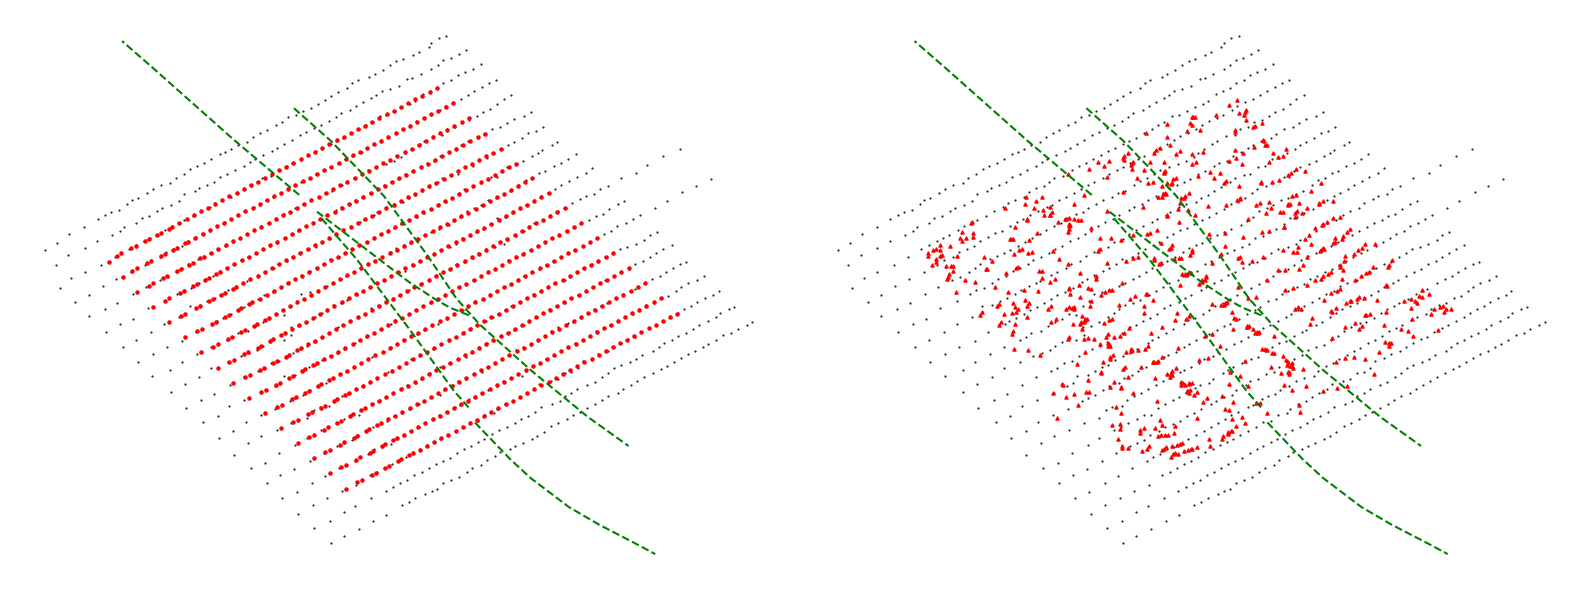

In [89]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
ax.scatter(loc_targets['lon_centroid'],loc_targets['lat_centroid'],c='r',marker='.',s=20)
for i in range(len(faults)):
    ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'g--')
ax.axis('off')
    
ax = fig.add_subplot(122)
ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
for i in range(len(faults)):
    ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'g--')
ax.scatter(lon_centroid_all_new.values(),lat_centroid_all_new.values(),c='r',marker='^',s=5)
ax.axis('off')
plt.tight_layout()
plt.savefig(dir_image + 'station_distribution.png')

In [90]:
key_probe = {}
key_probe_accept = {}
for key_subwork in key_subworks_new:
    key_target = key_subwork[:key_subwork.find('--')]
    probes_this = extract_probes(key_target)
    key_probe[key_subwork] = probes_this
    key_probe_accept[key_subwork] = probe_accept_all[key_target]
info_basic_bi['probe'] = key_probe
info_basic_bi['probe_accept'] = key_probe_accept

### Save to new subworks

In [91]:
# 将key的坐标写入excel
filename = dir_project+'stations_info.xlsx'
if os.path.exists(filename):
    os.remove(filename)
df=pd.DataFrame()
df['key_subwork'] = list(stations_accept_all_new.keys())
df['lon_centroid'] = list(lon_centroid_all_new.values())
df['lat_centroid'] = list(lat_centroid_all_new.values())
#写入excel的"location"sheet中
df.to_excel(filename,sheet_name='location',index=False)

In [1]:
writers = pd.ExcelWriter(filename, engine='openpyxl')
#writers.book = books
for key in stations_accept_all_new.keys():
    df=pd.DataFrame()
    df['Station'] = list(stations_accept_all_new[key])
    df['latitude'] = [lat_all[stalist_all.index(station)] for station in stations_accept_all_new[key]]
    df['longitude'] = [lon_all[stalist_all.index(station)] for station in stations_accept_all_new[key]]
    df.to_excel(writers, sheet_name=key,index=False)
writers._save()

NameError: name 'load_workbook' is not defined

In [93]:
filename = dir_project + 'subwork_location.xlsx'
df=pd.DataFrame()
df['key_subwork'] = [str(key_subwork) for key_subwork in key_subworks_new]  
df['lon_centroid'] = list(lon_centroid_all_new.values())
df['lat_centroid'] = list(lat_centroid_all_new.values())
df.to_excel(filename,sheet_name='location',index=False)

In [94]:
info_basic['key_subworks'] = list(stations_accept_all_new.keys())
info_basic['stalistname_all'] = info_basic_probes['stalistname_all']
info_basic['stalistname'] = 'stations_info.xlsx'

In [95]:
info_basic_bi['probe_accept'] = probe_accept_all

In [96]:
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)
np.save(dir_project + 'Basic_info.npy', info_basic_bi)